In [108]:
import os
import json
import glob
import copy
import random
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from pycococreatortools import pycococreatortools
import matplotlib.pyplot as plt

from viz_utils import *
import pycocotools.mask as mask_utils
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [7]:
BASEDIR = '/data/imaterialist2019'

with open(os.path.join(BASEDIR, 'label_descriptions.json'), 'r') as f :
    label_descriptions = json.load(f)

train_df = pd.read_csv(os.path.join(BASEDIR, 'train.csv'))
train_df['ClassId'] = train_df['ClassId'].astype(str)

In [8]:
imaterialist2int = {
    '24': '0', # bag
    '19': '1', # belt
}
imaterialist2int.update({str(k):'2' for k in [2,3,4,5,9,11,12]}) # outer 
imaterialist2int['10'] = '3' # dress
imaterialist2int['13'] = '4' # sunglasses
imaterialist2int.update({str(k):'5' for k in [6, 21]}) # pants 
imaterialist2int.update({str(k):'6' for k in [0, 1]}) # top
imaterialist2int['7'] = '7' # shorts
imaterialist2int['8'] = '8' # skirt
imaterialist2int.update({str(k):'9' for k in [14, 15]}) # headwear
imaterialist2int.update({str(k):'10' for k in [16, 25]}) # scarf & tie

classnames = ['bag', 'belt', 'outer', 'dress', 'sunglasses', 
              'pants', 'top', 'shorts', 'skirt', 'headwear', 'scarf & tie']

def relabel_classes(classid) :
    if '_' in classid :
        category = classid.split('_')[0]
    else :
        category = classid
    if category in imaterialist2int :
        return imaterialist2int[category]
    else :
        return None
    
train_df['ClassId'] = train_df['ClassId'].map(imaterialist2int)
train_df = train_df[~train_df['ClassId'].isnull()]
unique_imgids = list(train_df['ImageId'].unique())

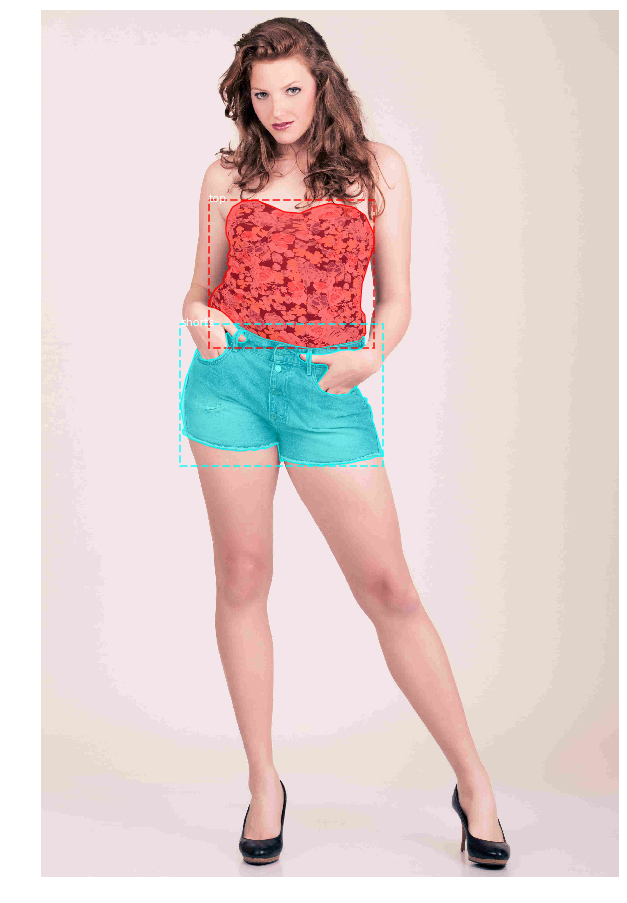

In [9]:
imgid = random.sample(unique_imgids, k=1)[0]
example_df = train_df[train_df['ImageId']==imgid]
img = np.array(Image.open(os.path.join(BASEDIR, 'train', imgid)).convert('RGB'))

masks = []
classids = []
bboxes = []
for instanceid in range(example_df.shape[0]) :
    width, height = example_df.iloc[instanceid]['Width'], example_df.iloc[instanceid]['Height']
    mask = rleToMask(example_df.iloc[instanceid]['EncodedPixels'], height, width)
    masks.append(mask)
    classids.append(example_df.iloc[instanceid]['ClassId'])
    
    bbox = makeBBox(mask)
    bboxes.append(bbox)
    
classids = np.array(list(map(int, classids)))
masks = np.stack(masks, axis=2)
bboxes = np.stack(bboxes, axis=0)
display_instances(img, boxes=bboxes, masks=masks, class_ids=classids, class_names=classnames)

### turn into COCO format

In [18]:
annotations = []
images = []
filenames = list(train_df['ImageId'].unique())
ann_id = 0
for filename in tqdm(list(filenames)) :
    try :
        img_annotations = train_df[train_df['ImageId']==filename]
        imgid = filename.split('.')[0]
        width_, height_ = int(img_annotations.iloc[0]['Width']), int(img_annotations.iloc[0]['Height'])
        image_info = pycococreatortools.create_image_info(
                imgid, os.path.basename(filename), (width_, height_))
        image_ = {}
        image_['image'] = image_info
        with open(os.path.join('/data/imaterialist2019/tmp_annos/images', str(imgid) + '.json'), 'w') as f :
            json.dump(image_, f)
        for ann_ix in range(img_annotations.shape[0]) :
            example = img_annotations.iloc[ann_ix, :]
            width, height = int(example['Width']), int(example['Height'])
            assert(width==width_)
            assert(height==height_)
            mask = rleToMask(example['EncodedPixels'], height, width)
            category_info = {'id': int(example['ClassId'])+1, 'is_crowd': False}
            ann_info = pycococreatortools.create_annotation_info(
                                    ann_id, imgid, category_info, mask,
                                    (width, height), tolerance=2)
            ann_info['segmentation'] = [[int(i) for i in seg] for seg in ann_info['segmentation']]
            ann_info['bbox'] = list(map(int, ann_info['bbox']))
#             annotations.append(ann_info)
            ann_id += 1
            
            ann_ = {}
            ann_['annotation'] = ann_info
            with open(os.path.join('/data/imaterialist2019/tmp_annos/annotations', str(ann_id) + '.json'), 'w') as f :
                json.dump(ann_, f)
#         images.append(image_info)
    except :
        print(filename)

c7a64a2b76ca01c98f098f91df4d16cd.jpg



### load saved files and turn into COCO format

In [20]:
data = {}
data['categories'] = [{'supercategory': 'fashion', 'id': 1, 'name': 'bag'},
 {'supercategory': 'fashion', 'id': 2, 'name': 'belt'},
 {'supercategory': 'fashion', 'id': 3, 'name': 'outer'},
 {'supercategory': 'fashion', 'id': 4, 'name': 'dress'},
 {'supercategory': 'fashion', 'id': 5, 'name': 'sunglasses'},
 {'supercategory': 'fashion', 'id': 6, 'name': 'pants'},
 {'supercategory': 'fashion', 'id': 7, 'name': 'top'},
 {'supercategory': 'fashion', 'id': 8, 'name': 'shorts'},
 {'supercategory': 'fashion', 'id': 9, 'name': 'skirt'},
 {'supercategory': 'fashion', 'id': 10, 'name': 'headwear'},
 {'supercategory': 'fashion', 'id': 11, 'name': 'scarf/tie'}]

In [50]:
data['images'] = []
data['annotations'] = []

In [51]:
annotations = glob.glob('/data/imaterialist2019/tmp_annos/annotations/*.json')
images = glob.glob('/data/imaterialist2019/tmp_annos/images/*.json')

In [52]:
for imgfile in images :
    with open(imgfile) as f :
        imginfo = json.load(f)
    data['images'].append(imginfo['image'])

In [53]:
for imgfile in annotations :
    with open(imgfile) as f :
        annotation = json.load(f)
    data['annotations'].append(annotation['annotation'])

In [58]:
ids = set([imginfo['id'] for imginfo in data['images']])

<class 'int'>


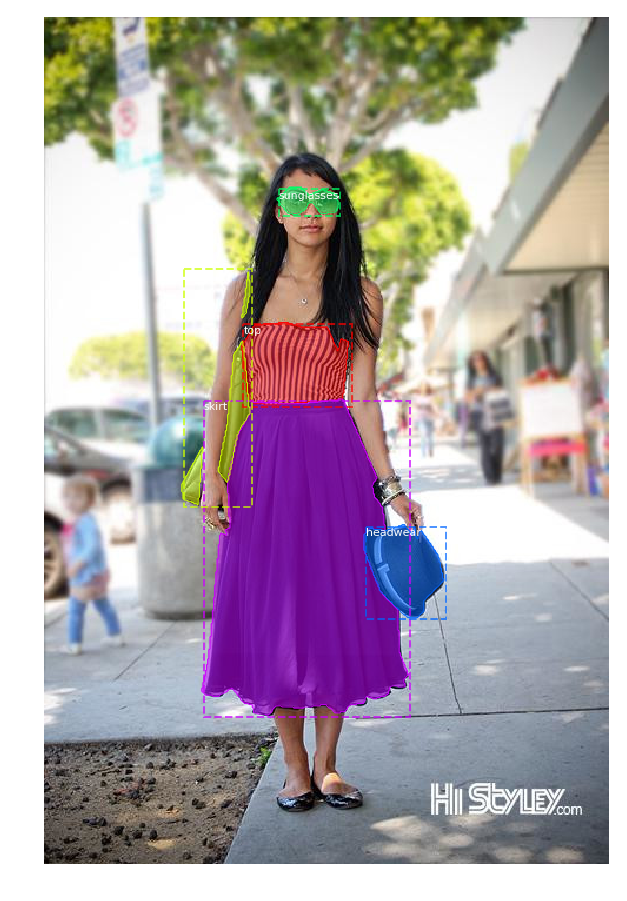

In [69]:
rand_imgid = random.sample(ids, k=1)[0]
imginfo = [img for img in data['images'] if img['id']==rand_imgid][0]
annotations = [ann for ann in data['annotations'] if ann['image_id']==rand_imgid]
img = np.array(Image.open(os.path.join('/data/imaterialist2019/train', imginfo['file_name'])))
viz_coco_example(img, imginfo, annotations, classnames)

In [77]:
with open('/data/imaterialist2019/annotations/annotations.json', 'w') as f :
    json.dump(data, f)

## make train and val splits

In [78]:
with open('/data/imaterialist2019/annotations/annotations.json', 'r') as f :
    anns = json.load(f)

<class 'int'>


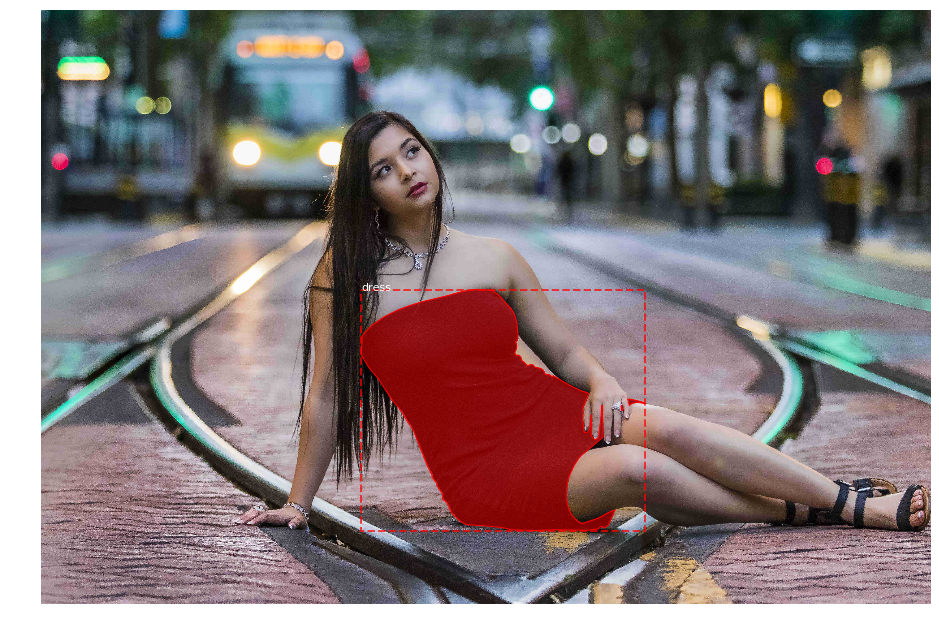

In [80]:
ids = set([imginfo['id'] for imginfo in data['images']])
rand_imgid = random.sample(ids, k=1)[0]
imginfo = [img for img in data['images'] if img['id']==rand_imgid][0]
annotations = [ann for ann in data['annotations'] if ann['image_id']==rand_imgid]
img = np.array(Image.open(os.path.join('/data/imaterialist2019/train', imginfo['file_name'])))
viz_coco_example(img, imginfo, annotations, classnames)

In [88]:
ids = list(ids)
random.shuffle(ids)
num_train = int(len(ids)*0.95)
trainids = ids[:num_train]
valids = ids[num_train:]

In [90]:
anns_ = {}
anns_['categories'] = anns['categories']
anns_['images'] = []
anns_['annotations'] = []

In [93]:
traindata = copy.deepcopy(anns_)
valdata = copy.deepcopy(anns_)

In [94]:
for imgdata in anns['images'] :
    if imgdata['id'] in trainids :
        traindata['images'].append(imgdata)
    else :
        valdata['images'].append(imgdata)

In [95]:
for annotation in data['annotations']:
    if annotation['image_id'] in trainids :
        traindata['annotations'].append(annotation)
    else :
        valdata['annotations'].append(annotation)

In [98]:
with open('/data/imaterialist2019/annotations/train_latest.json', 'w') as f :
    json.dump(traindata, f)

In [99]:
with open('/data/imaterialist2019/annotations/val_latest.json', 'w') as f :
    json.dump(valdata, f)

In [100]:
with open('/data/imaterialist2019/annotations/train_latest.json', 'r') as f :
    train_anns = json.load(f)
ids = set([imginfo['id'] for imginfo in train_anns['images']])

<class 'int'>


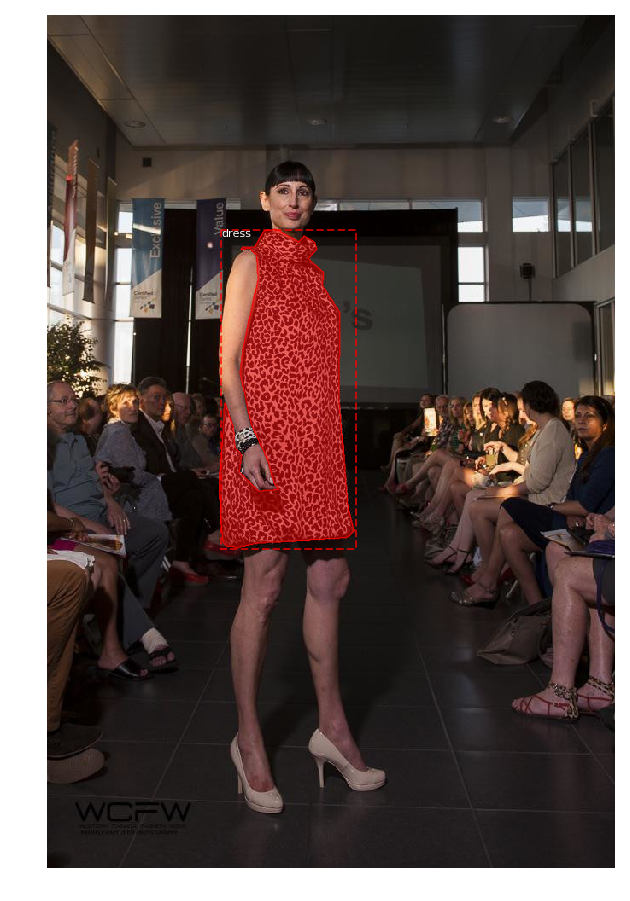

In [105]:
rand_imgid = random.sample(ids, k=1)[0]
imginfo = [img for img in train_anns['images'] if img['id']==rand_imgid][0]
annotations = [ann for ann in train_anns['annotations'] if ann['image_id']==rand_imgid]
img = np.array(Image.open(os.path.join('/data/imaterialist2019/train', imginfo['file_name'])))
viz_coco_example(img, imginfo, annotations, classnames)

In [111]:
# move over all the train images from train to images/train 
with open('/data/imaterialist2019/annotations/train_latest.json', 'r') as f :
    train_anns = json.load(f)

for imageinfo in train_anns['images'] :
    filename = imageinfo['file_name']
    shutil.move(os.path.join('/data/imaterialist2019/train', filename), 
               os.path.join('/data/imaterialist2019/images/train', filename))

In [110]:
# move over all the train images from train to images/train 
with open('/data/imaterialist2019/annotations/val_latest.json', 'r') as f :
    val_anns = json.load(f)

for imageinfo in val_anns['images'] :
    filename = imageinfo['file_name']
    shutil.move(os.path.join('/data/imaterialist2019/val', filename), 
               os.path.join('/data/imaterialist2019/images/train', filename))

{'id': '00000663ed1ff0c4e0132b9b9ac53f6e',
 'file_name': '00000663ed1ff0c4e0132b9b9ac53f6e.jpg',
 'width': 3676,
 'height': 5214,
 'date_captured': '2019-04-27 00:31:21.566850',
 'license': 1,
 'coco_url': '',
 'flickr_url': ''}